In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
import cv2
from functools import partial
import itertools

from tensorflow.keras import Model
import json

from scipy import spatial
from random import sample
gray = 1
color = 3


2022-09-29 15:23:51.985195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 15:23:52.083651: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 15:23:52.106693: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 15:23:52.570731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
gpus = tf.config.list_physical_devices('GPU')

2022-09-29 15:23:53.564702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:23:53.588630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:23:53.589065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
use_crop = True
ref = 200

In [4]:
if use_crop: 
    fmt = '_crop'
    target_shape = (ref,ref)
    regular_path = 'Images/regular_crop/'
    blurred_path = 'Images/regular_crop_blur/'
    noise_path = 'Images/regular_crop_noise/'
else: 
    fmt = ''
    target_shape = (ref,int(ref*a.shape[0]/a.shape[1])) 
    regular_path = 'Images/regular/'
    blurred_path = 'Images/regular_blur/'
    noise_path = 'Images/regular_noise/'

In [5]:
def preprocess_image(filename, to_gray=False): 
    
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)    
    image = tf.image.resize(image, target_shape)
    if to_gray: 
        image = tf.image.rgb_to_grayscale(image)
        image = tf.repeat(image[...,tf.newaxis], 3,-1)
        image = tf.reshape(image, (200,200,3))
    return image 

def preprocess_triplets(anchor, positive, negative, to_gray=False): 
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    return (
            preprocess_image(anchor, to_gray),
            preprocess_image(positive, to_gray),
            preprocess_image(negative, to_gray),
        )


In [6]:
(300,200) +(2,)

(300, 200, 2)

In [7]:
folders = os.listdir(regular_path)[1:]
mapping = {}
all_pairs = []
for x in folders:
    anchor_image_files = os.listdir(regular_path + x)
    positive_image_files = [blurred_path + x for y in anchor_image_files] 
    positive_image_files.extend([regular_path + x for y in anchor_image_files])
    pairs = list(itertools.product(anchor_image_files, positive_image_files))
    all_pairs.append(pairs)
    mapping[x] = {}
    mapping[x]['anchor'] = [(pairs[0][1] + '/'+ pairs[0][0]).replace('regular_crop_blur', 'regular_crop')  for x in pairs] #[regular_path + x + '/' + y for y in  [x[0] for x in pairs]]
    mapping[x]['positive'] =  [pairs[1][1] + '/' + pairs[1][0] for x in pairs] #[blurred_path + x + '/' + y  for y in [x[1] for x in pairs]]
    # mapping[x]['positive'].extend([noise_path + x  + '/' + y for y in  image_files])


In [8]:
all_pairs[0]

[('44256816.jpg', 'Images/regular_crop_blur/1st_Movement_Solo'),
 ('44256816.jpg', 'Images/regular_crop/1st_Movement_Solo')]

In [9]:
sorted_keys = sorted(mapping)
all_pairs = []
card_image_files = os.listdir(regular_path)[1:]
for card in sorted_keys: 
    ls = os.listdir(regular_path + '/' + card)
    for num in ls: 
        all_pairs.append((card, num))
mapping_copy = mapping.copy()

In [10]:
# anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
# positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)


# # To generate the list of negative images, let's randomize the list of
# # available images and concatenate them together.
# rng = np.random.RandomState(seed=42)
# rng.shuffle(anchor_images)
# rng.shuffle(positive_images)
# negative_images = anchor_images + positive_images
# np.random.RandomState(seed=32).shuffle(negative_images)


# negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
# negative_dataset = negative_dataset.shuffle(buffer_size=24000)

# preprocess_triplets = partial(preprocess_triplets, to_gray=False)
# dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
# dataset = dataset.shuffle(buffer_size=12000)
# dataset = dataset.map(preprocess_triplets, True)

In [11]:
def create_dataset2(to_gray=False):
    anchor_images = []
    positive_images = []
    exists = []
    duplicate = True
    for x in sorted_keys:

        anchor_images.extend(mapping[x]['anchor'])
        positive_images.extend(mapping[x]['positive'])

    # return anchor_images, positive_images
    image_count = len(anchor_images)
    print(image_count)
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)


    # To generate the list of negative images, let's randomize the list of
    # available images and concatenate them together.
    rng = np.random.RandomState(seed=42)
    ai = anchor_images.copy()
    pi = positive_images.copy()
    rng.shuffle(ai)
    rng.shuffle(pi)
    negative_images = ai + pi
    np.random.RandomState(seed=32).shuffle(negative_images)


    negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
    negative_dataset = negative_dataset.shuffle(buffer_size=24000)

    preprocess_triplets2 = partial(preprocess_triplets, to_gray=to_gray)
    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
    dataset = dataset.shuffle(buffer_size=12000)
    dataset = dataset.map(preprocess_triplets2, True)
    # return positive_images
    return anchor_dataset, positive_dataset, negative_dataset, dataset, image_count, positive_images, anchor_images

In [12]:
# def create_dataset():
#     anchor_images = []
#     positive_images = []
#     exists = []
#     duplicate = False
#     for x in sorted_keys:
#         print(x)
#         break
#         if duplicate: 
#             limit = 1
#         else: 
#             limit = 0
        
#         if len(mapping_copy[x]['anchor']) > limit: 
#             # print(x)
#             anchor_sample_file =  sample(mapping[x]['anchor'],1)[0]
#             anchor_images.append(anchor_sample_file)
#             # print(anchor_sample_file)
#             # mapping_copy[x]['anchor'].remove(anchor_sample_file)    
#             positive_sample_file = sample(mapping_copy[x]['anchor'] + mapping_copy[x]['positive'],1)[0]
#             positive_images.append(positive_sample_file)
            
#     image_count = len(anchor_images)
#     print(image_count)
#     anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
#     positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)


#     # To generate the list of negative images, let's randomize the list of
#     # available images and concatenate them together.
#     rng = np.random.RandomState(seed=42)
#     rng.shuffle(anchor_images)
#     rng.shuffle(positive_images)
#     negative_images = anchor_images + positive_images
#     np.random.RandomState(seed=32).shuffle(negative_images)


#     negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
#     negative_dataset = negative_dataset.shuffle(buffer_size=24000)

#     preprocess_triplets2 = partial(preprocess_triplets, to_gray=False)
#     dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
#     dataset = dataset.shuffle(buffer_size=12000)
#     dataset = dataset.map(preprocess_triplets2, True)
#     # return positive_images
#     return anchor_dataset, positive_dataset, negative_dataset, dataset, image_count

In [13]:
anchor_dataset, positive_dataset, negative_dataset, dataset, image_count, positive_images, anchor_images = create_dataset2()
# anchor_dataset2, positive_dataset2, negative_dataset2, dataset2, image_count = create_dataset()
# anchor_dataset3, positive_dataset3, negative_dataset3, dataset3, img_count = create_dataset()

# anchor_datset = anchor_dataset
# dataset = dataset1.concatenate(dataset2)





25630


2022-09-29 15:24:26.555955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 15:24:26.558390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:24:26.558867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:24:26.559292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may h

In [14]:
# Let's now split our dataset in train and validation.
val_dataset = dataset.skip(round(image_count * 0.1))
train_dataset = dataset.take(round(image_count * 0.1))

In [15]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(list(dict.fromkeys(anchor_images)))


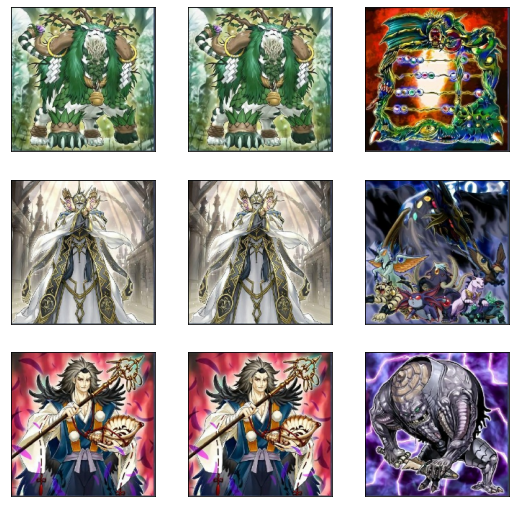

In [16]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

train_dataset1 = train_dataset.batch(32, drop_remainder=False)
train_dataset1 = train_dataset1.prefetch(8)
visualize(*list(train_dataset1.take(1).as_numpy_iterator())[0])

In [17]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    @tf.function
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
        

        
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
    
    @tf.function
    def call(self, inputs):
        return self.siamese_network(inputs)
    
    @tf.function
    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @tf.function
    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]        

In [18]:
import os

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14299087843194496267
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22663921664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17923104089556425019
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-09-29 15:24:28.414538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:24:28.415097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:24:28.415551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:24:28.416151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-29 15:24:28.416171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not ident

In [20]:
# train_dataset = dataset.take(round(image_count * 0.8))

# r = 0
# for i, x in enumerate(train_dataset):
#     r += 1
# print(r)

In [21]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [22]:
gpus = tf.config.list_logical_devices('GPU')
from tensorflow.keras.applications import resnet_v2

In [23]:
pretrained_model = 'RESNET50'
PRETRAINED_MODELS = {"RESNET50":resnet_v2.ResNet50V2, "RESNET101":resnet_v2.ResNet101V2, 'RESNET152':resnet_v2.ResNet152V2}

In [24]:

base_cnn = PRETRAINED_MODELS[pretrained_model](
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
dense3 = layers.Dense(128, activation="relu")(dense2) # Added
dense3 = layers.BatchNormalization()(dense3) # Added
output = layers.Dense(64)(dense3) # was 256

embedding_model = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable



anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding_model(resnet_v2.preprocess_input(anchor_input)),
    embedding_model(resnet_v2.preprocess_input(positive_input)),
    embedding_model(resnet_v2.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)
batch_size = 64
checkpoint_path = "model/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)
siamese_model = SiameseModel(siamese_network,1)
# strategy = tf.distribute.MirroredStrategy(gpus,)
# with strategy.scope():
siamese_model.compile(optimizer=optimizers.Adam(0.0001), weighted_metrics=[])
siamese_model.fit(train_dataset.batch(batch_size, drop_remainder=False), epochs=1, 
                  validation_data=val_dataset.batch(32, drop_remainder=False), 
                  callbacks=[cp_callback], verbose=2)


2022-09-29 15:24:37.855235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-29 15:24:38.487986: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-29 15:24:38.774913: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


41/41 - 175s - loss: 0.0392 - val_loss: 0.0253 - 175s/epoch - 4s/step


In [25]:
embedding_model.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [26]:
import tensorflow as tf

In [6]:
tf.Tensor(b'Images/regular_crop/1st_Movement_Solo/44256816.jpg', dtype='string', value_index=0)

TypeError: op needs to be an Operation. An instance of type bytes is provided.

In [19]:
embedding_model.save_weights('embedding/')

In [29]:
def preprocess_image(filename:str, to_gray:bool=False): 
        
        image_string = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)    
        image = tf.image.resize(image, target_shape)
        if to_gray: 
            image = tf.image.rgb_to_grayscale(image)
            image = tf.repeat(image[...,tf.newaxis], 3,-1)
            image = tf.reshape(image, target_shape + (3,))
        return image 

In [45]:
resnet_v2.preprocess_input(preprocess_image(tf.Variable('Images/regular_crop/Dark_Magician_Girl/38033121.jpg')))

<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[-0.9963341 , -0.9973299 , -0.9969377 ],
        [-0.9961196 , -0.9974217 , -0.99716866],
        [-0.9959909 , -0.9973038 , -0.9972531 ],
        ...,
        [-0.99614656, -0.99747294, -0.99708116],
        [-0.99704766, -0.9973629 , -0.9968631 ],
        [-0.9976961 , -0.997742  , -0.9970356 ]],

       [[-0.9967704 , -0.9984876 , -0.99823195],
        [-0.9966766 , -0.9986605 , -0.9985836 ],
        [-0.99662447, -0.9986306 , -0.99874014],
        ...,
        [-0.99698603, -0.99860966, -0.99823076],
        [-0.99770135, -0.99810493, -0.9975799 ],
        [-0.99796677, -0.9980976 , -0.9974254 ]],

       [[-0.99654484, -0.9987213 , -0.998621  ],
        [-0.9963228 , -0.9988111 , -0.99883807],
        [-0.99633735, -0.9988364 , -0.9990421 ],
        ...,
        [-0.9968051 , -0.99870974, -0.99837154],
        [-0.9976221 , -0.998234  , -0.99773633],
        [-0.99790883, -0.99816066, -0.9974599 ]],

       ...,

     

In [31]:
from tensorflow.keras.applications import resnet_v2

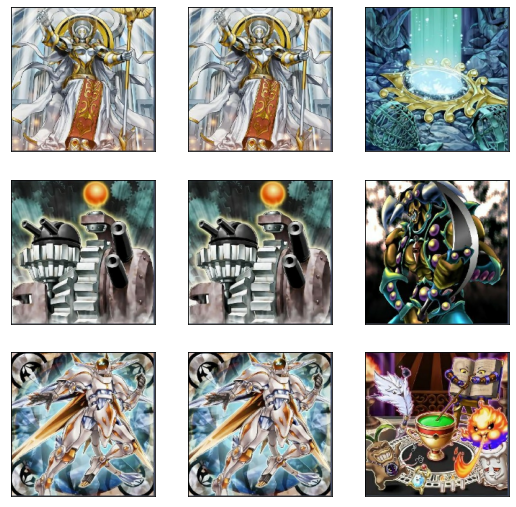

In [46]:
sample = next(iter(train_dataset.batch(32, drop_remainder=False).prefetch(8)))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(resnet_v2.preprocess_input(anchor)),
    embedding_model(resnet_v2.preprocess_input(positive)),
    embedding_model(resnet_v2.preprocess_input(negative)),
)

In [47]:
resnet_v2.preprocess_input(anchor)

<tf.Tensor: shape=(32, 200, 200, 3), dtype=float32, numpy=
array([[[[-0.99528414, -0.99528414, -0.9949607 ],
         [-0.9952051 , -0.9952051 , -0.9949129 ],
         [-0.9954325 , -0.9954325 , -0.9951442 ],
         ...,
         [-0.9952328 , -0.9948699 , -0.9949553 ],
         [-0.99792194, -0.9973305 , -0.997053  ],
         [-0.99816996, -0.99744415, -0.9969792 ]],

        [[-0.9924237 , -0.99245256, -0.9922656 ],
         [-0.99247503, -0.9925038 , -0.99234223],
         [-0.99255073, -0.99255073, -0.99247766],
         ...,
         [-0.9923402 , -0.99222785, -0.992513  ],
         [-0.99788725, -0.9975894 , -0.9974165 ],
         [-0.9981028 , -0.9976978 , -0.99724156]],

        [[-0.9924565 , -0.99246573, -0.9923873 ],
         [-0.992377  , -0.9923932 , -0.99242395],
         [-0.9925382 , -0.9925884 , -0.99269426],
         ...,
         [-0.99540395, -0.9954521 , -0.99601173],
         [-0.9975452 , -0.9974521 , -0.99741226],
         [-0.99808496, -0.9978555 , -0.997471

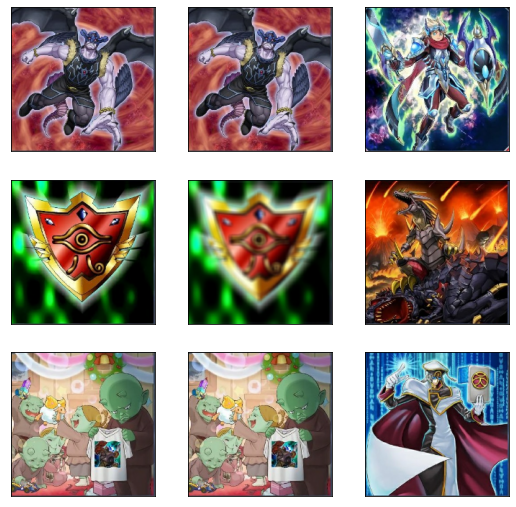

In [48]:
sample = next(iter(val_dataset.batch(32, drop_remainder=False).prefetch(8)))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(resnet_v2.preprocess_input(anchor)),
    embedding_model(resnet_v2.preprocess_input(positive)),
    embedding_model(resnet_v2.preprocess_input(negative)),
)

In [37]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       mapping: 576.1 KiB
                  mapping_copy: 576.1 KiB
               positive_images: 217.5 KiB
                 anchor_images: 217.5 KiB
                   sorted_keys: 106.8 KiB
                     all_pairs: 96.3 KiB
                       folders: 94.9 KiB
              card_image_files: 94.9 KiB
                          _i17:  9.1 KiB
                 DistanceLayer:  2.0 KiB


In [38]:
import gc
# del ANCHOR_EMBEDDINGS
gc.collect()

22396

In [1]:
from tensorflow.keras.applications import resnet, mobilenet

2022-09-29 18:45:18.763599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 18:45:18.865987: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 18:45:18.887281: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 18:45:19.325252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [39]:
anchor_paths = [f'Images/regular_crop/{x[0]}/{x[1]}' for x in all_pairs]


In [3]:
import tensorflow as tf
a = tf.Variable([preprocess_image('Images/regular_crop/Dark_Sacrifice/76045757.jpg')])
resnet_v2.preprocess_input(a)

NameError: name 'preprocess_image' is not defined

In [52]:
target_shape = (200,200)

In [53]:
def preprocess_and_embed(x): 
    x = tf.Variable([preprocess_image(x)])
    x = resnet_v2.preprocess_input(x)
    x = embedding_model(x)
    return x


def fetch_anchor_embeddings(save=True, num_cores=8): 
    ANCHOR_EMBEDDINGS = []
    i = 0 
    tmp = tf.data.Dataset.from_tensor_slices(anchor_paths)
    ############################
    for img in tmp:
        if i % 1000 == 0 : 
            print(i)
        ANCHOR_EMBEDDINGS.append(preprocess_and_embed(img))
        i += 1
    ############################
    # pool = mp.Pool(num_cores)
    # ANCHOR_EMBEDDINGS = pool.map(preprocess_and_embed, tmp)
    ANCHOR_EMBEDDINGS = [x for x in ANCHOR_EMBEDDINGS]
    ANCHOR_EMBEDDINGS = [x.numpy().tolist() for x in ANCHOR_EMBEDDINGS]
    ANCHOR_EMBEDDINGS = [x[0] for x in ANCHOR_EMBEDDINGS]
    anchor_labels = [x.numpy() for x in tmp]
    anchor_labels = [str(x).split('/')[-2] for x in anchor_labels]
    embedding_vec = dict(zip(anchor_paths, ANCHOR_EMBEDDINGS))
    if save: 
        with open(f'Images/anchor_embedding_128_{pretrained_model}.json', 'w') as outfile:
            json.dump(embedding_vec, outfile)
    return embedding_vec

In [54]:
preprocess_and_embed('Images/regular_crop/Dark_Advance/97001138.jpg')

RuntimeError: `var /= value` with `tf.Variable`s is not supported. Use `var.assign(var / value)` to modify the variable, or `out = var / value` if you need to get a new output Tensor.

In [55]:
embedding_vec = fetch_anchor_embeddings()

0


RuntimeError: `var /= value` with `tf.Variable`s is not supported. Use `var.assign(var / value)` to modify the variable, or `out = var / value` if you need to get a new output Tensor.

In [38]:
# embedding_model.save_weights(f'models/embedding_model_{pretrained_model}.ckpt')

In [72]:
i = 0 
tmp = tf.data.Dataset.from_tensor_slices(anchor_paths)
############################
for img in tmp:
    if i % 1000 == 0 : 
        print(i)
    # ANCHOR_EMBEDDINGS.append(preprocess_and_embed(img))
    i += 1
print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
12305


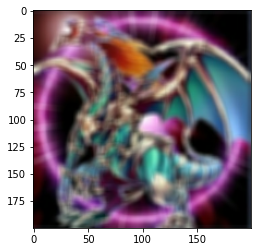

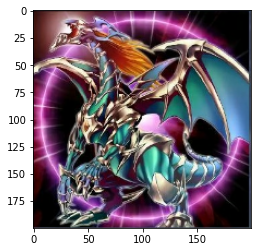

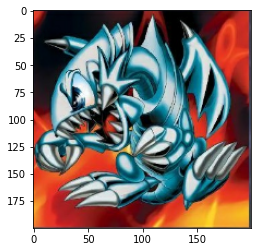

In [73]:
test_image_blur = preprocess_image(f'Images/regular{fmt}_blur/Chaos_Emperor_Dragon_-_Envoy_of_the_End/82301904.jpg', False)
test_image = preprocess_image(f'Images/regular{fmt}/Chaos_Emperor_Dragon_-_Envoy_of_the_End/82301904.jpg', False)
test_negative_image = preprocess_image(f'Images/regular{fmt}/Blue-Eyes_Toon_Dragon/53183600.jpg', False)
plt.imshow(test_image_blur)
plt.show()
plt.imshow(test_image)
plt.show()
plt.imshow(test_negative_image)

In [74]:
crop = '_crop'

In [75]:
# bls_reg = embedding_model(np.array(resnet.preprocess_input([test_image])))
# bls_blur = embedding_model(np.array(resnet.preprocess_input([test_image_blur])))
# neg_reg = embedding_model(np.array(resnet.preprocess_input([test_negative_image])))

bls_reg = preprocess_and_embed(tf.Variable(f'Images/regular{crop}/Black_Luster_Soldier_-_Envoy_of_the_Beginning/72989439.jpg'))
bls_blur = preprocess_and_embed(tf.Variable(f'Images/regular{crop}_blur/Black_Luster_Soldier_-_Envoy_of_the_Beginning/72989439.jpg'))
neg_reg = preprocess_and_embed(tf.Variable(f'Images/regular{crop}/Blue-Eyes_Toon_Dragon/53183600.jpg'))

test_img = preprocess_and_embed(tf.Variable(f'Images/regular{crop}_blur//Invoked_Mechaba/75286621.jpg'))

In [44]:
import json 
import pandas as pd
from tensorflow import metrics
cosine_similarity = metrics.CosineSimilarity()

# f = open('Images/anchor_embedding.json')

# embedding_vec = json.load(f)

In [45]:
import pandas as pd
embedding_df = pd.Series(embedding_vec).reset_index().rename(columns={'index':'name', 0:'embedding'})

In [46]:
embedding_df['euclidean_distance'] = embedding_df['embedding'].apply(lambda x: np.linalg.norm(np.array(x) - bls_reg[0].numpy()))

In [47]:
def norm(x, y): 
    return np.linalg.norm(np.array(x[0]) - y)
norm = np.vectorize(norm)

In [97]:
ANCHOR_EMBEDDINGS = np.array([np.array(x) for x in list(embedding_vec.values())])
labels = [x.split('/')[-2] for x in list(embedding_vec)]
ANCHOR_EMBEDDINGS2 = np.stack(ANCHOR_EMBEDDINGS).astype('float32')
ANCHOR_EMBEDDINGS2.shape

(12305, 64)

In [98]:
# anchor_labels = [x.numpy() for x in anchor_dataset]
# anchor_labels = [str(x).split('/')[-2] for x in anchor_labels]

In [99]:
anchor_labels = labels

In [100]:
import faiss

def setup_faiss_index(data, metric='L2'):
    feature_length = data.shape[1]
    if metric=='L2': 
        index = faiss.IndexFlatL2(feature_length)
        index.add(data)
    if metric == 'cosine':
        index = faiss.index_factory(feature_length, 'Flat',faiss.METRIC_INNER_PRODUCT)
        index.ntotal
        faiss.normalize_L2(data)
        index.add(data)
    return index, metric

In [101]:
index_cosine, metric_cosine = setup_faiss_index(ANCHOR_EMBEDDINGS2, metric='cosine')
index_l2, metric_l2 = setup_faiss_index(ANCHOR_EMBEDDINGS2, metric='L2')


In [102]:
len(list(embedding_vec))

12305

In [103]:
def search_image(img_path, index, k=5,): 
    embed_vector = preprocess_and_embed(tf.Variable(img_path))
    D, I = index.search(embed_vector.numpy(), k)
    # print(I)
    # return I[0]
    
    return [anchor_labels[i] for i in  I[0].tolist()]

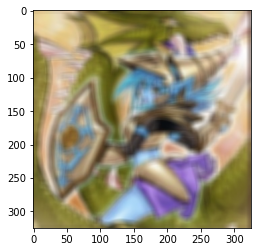

In [104]:
plt.imshow(cv2.imread('Images/regular_crop_blur/Dark_Magician_Girl_the_Dragon_Knight/43892409.jpg'))

Images/regular_crop/Giga_Gagagigo/43793530.jpg


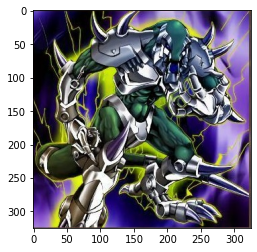

In [105]:
from random import sample
nm = sample(os.listdir('Images/regular_blur/')[1:],1)[0]
nm1 = sample(os.listdir('Images/regular_crop/' + nm + '/'),1) 

path = f'Images/regular_crop/{nm}/{nm1[0]}'
print(path)
# path = 'Images/regular_crop/{nm}/97973962.jpg'
plt.imshow(cv2.imread(path))

In [106]:
positive_image_files

['Images/regular_crop_blur/______Infernoble_Arms_-_Joyeuse______',
 'Images/regular_crop/______Infernoble_Arms_-_Joyeuse______']

In [108]:
test_blur = [x.replace('regular_crop', 'regular_crop_blur') for x in list(dict.fromkeys(positive_images))]

In [80]:
bls_reg = preprocess_and_embed(tf.Variable(f'Images/regular_crop/Chaos_Emperor_Dragon_-_Envoy_of_the_End/82301904.jpg'))
bls_blur = preprocess_and_embed(tf.Variable(f'Images/regular_crop_blur/Chaos_Emperor_Dragon_-_Envoy_of_the_End/82301904.jpg'))
bls_noise = preprocess_and_embed(tf.Variable(f'Images/regular_crop_blur/Mirror_Force_Dragon/84687358.jpg'))

neg_reg = preprocess_and_embed(tf.Variable(f'Images/regular_crop/Red-Eyes_Baby_Dragon/58257569.jpg'))


In [82]:
[x.replace('regular_crop', 'regular_crop_blur') for x in p]

['Images/regular_crop/1st_Movement_Solo/44256816.jpg',
 'Images/regular_crop/1st_Movement_Solo/44256816.jpg',
 'Images/regular_crop/3-Hump_Lacooda/86988864.jpg',
 'Images/regular_crop/3-Hump_Lacooda/86988864.jpg',
 'Images/regular_crop/30,000-Year_White_Turtle/11714098.jpg',
 'Images/regular_crop/30,000-Year_White_Turtle/11714098.jpg',
 'Images/regular_crop/4-Starred_Ladybug_of_Doom/83994646.jpg',
 'Images/regular_crop/4-Starred_Ladybug_of_Doom/83994646.jpg',
 'Images/regular_crop/7/67048711.jpg',
 'Images/regular_crop/7/67048711.jpg',
 'Images/regular_crop/7_Colored_Fish/23771716.jpg',
 'Images/regular_crop/7_Colored_Fish/23771716.jpg',
 'Images/regular_crop/7_Completed/86198326.jpg',
 'Images/regular_crop/7_Completed/86198326.jpg',
 'Images/regular_crop/8-Claws_Scorpion/14261867.jpg',
 'Images/regular_crop/8-Claws_Scorpion/14261867.jpg',
 'Images/regular_crop/A-Assault_Core/30012506.jpg',
 'Images/regular_crop/A-Assault_Core/30012506.jpg',
 'Images/regular_crop/A-Team--_Trap_Disposal

In [ ]:
results_blur = [search_image(x,index_cosine, k=20) for x in test_blur]


2022-09-21 07:17:35.154320: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: Images/regular_crop_blur_blur/Acid_Trap_Hole/41356845.jpg; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} Images/regular_crop_blur_blur/Acid_Trap_Hole/41356845.jpg; No such file or directory [Op:ReadFile]

In [ ]:
names = [x.split('/')[-2] for x in positive_images]


In [ ]:
count = 0
final = []
k = np.arange(1,20)
for j in range(1,20):
    for i, x in enumerate(names):
        if x in results[i][:j]: 
            count += 1
    final.append(count/len(names))
    count = 0
count/len(names) 
    

In [ ]:
final

In [111]:
%%timeit
r = search_image('Images/regular_crop_blur/Aleister_the_Invoker/86120752.jpg', index_cosine)

57.1 ms ± 898 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
search_image('Images/regular_crop/Aleister_the_Invoker/86120752.jpg', index_cosine)

['Aleister_the_Invoker',
 'Unpossessed',
 'Brotherhood_of_the_Fire_Fist_-_Dragon',
 'Interplanetarypurplythorny_Dragon',
 'Kozmo_Soartroopers']

In [115]:
%%timeit
r = search_image('Images/regular_crop_blur/Mekk-Knight_Purple_Nightfall/28692962.jpg', index_cosine)

57.9 ms ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:

embed_vector = preprocess_and_embed(tf.Variable('Images/regular_crop_blur/Mekk-Knight_Purple_Nightfall/28692962.jpg'))


39.2 ms ± 929 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [132]:
cd Images/regular_crop_blur/Red_Archery_Girl/

/mnt/c/Users/nmagh/Desktop/projects/YGOSiamese/Images/regular_crop_blur/Red_Archery_Girl


In [133]:
ls

65570596.jpg


In [135]:
cd ..

/mnt/c/Users/nmagh/Desktop/projects/YGOSiamese/Images/regular_crop_blur


In [138]:
cd ..

/mnt/c/Users/nmagh/Desktop/projects/YGOSiamese
